This notebook is a continuation of `3_activations_gradients_batchnorm` wherein the previously developed logic is reimplemented here as a collection of classes.

In [1]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
class Linear:
    """A basic linear unit representing the operation y = xA^T + b with optional bias."""

    def __init__(
        self,
        fan_in: float,
        fan_out: float,
        bias: bool = True,
        generator: "object" = None,
    ):
        kaiming_init = fan_in**0.5
        self.weight = torch.randn((fan_in, fan_out), generator=generator) / kaiming_init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: "torch.tensor") -> "torch.tensor":
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    @property
    def parameters(self) -> "list[torch.tensor]":
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    """Basic 1D batchnorm implementation that maintains stats during training."""

    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)  # batch norm gain
        self.beta = torch.zeros(dim)  # batch norm shift

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: "torch.tensor") -> "torch.tensor":
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_var = x.var(0, keepdim=True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var

        x_hat = (x - x_mean) / torch.sqrt(x_var + self.eps)
        self.out = self.gamma * x_hat + self.beta

        # Track the batch-norm statistics as training progresses
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
        return self.out

    @property
    def parameters(self) -> "list[torch.tensor]":
        """Returns the gain and the norm shift as a list of tensors."""
        return [self.gamma, self.beta]


class Tanh:
    """Wrapper around the torch.tanh activation function."""

    def __call__(self, x: "torch.tensor"):
        self.out = torch.tanh(x)
        return self.out

    @property
    def parameters(self) -> "list":
        return []

In [3]:
# Construct the list of names and produce a dataset
words = list()
with open("names.txt", "r") as infile:
    for line in infile:
        words.append(line.strip())

# Mapping of characters to/from integers
special = "."
chars = sorted(list(set("".join(words))))
STOI = {s: i + 1 for i, s in enumerate(chars)}
STOI[special] = 0
ITOS = {i: s for s, i in STOI.items()}

vocab_size = len(STOI)

In [4]:
# Construct the dataset


def build_dataset(words, *, special: str = ".", block_size: int = 3) -> "tuple[torch.tensor]":
    (X, Y) = (list(), list())

    for word in words:
        context = [0] * block_size
        for char in word + special:
            ix = STOI[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"Constructed dataset: X: {X.shape}, Y: {Y.shape}")
    return X, Y


# Train, Development, Test split
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

Constructed dataset: X: torch.Size([182346, 3]), Y: torch.Size([182346])
Constructed dataset: X: torch.Size([23003, 3]), Y: torch.Size([23003])
Constructed dataset: X: torch.Size([22797, 3]), Y: torch.Size([22797])


In [5]:
# Re-create the training loop with an improved model instantiation

n_embed = 10
n_hidden = 100
block_size = 3
fan_in = n_embed * block_size
generator = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=generator)

layers = [
    Linear(fan_in=fan_in, fan_out=n_hidden, generator=generator),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=generator),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=generator),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=generator),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=n_hidden, generator=generator),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(fan_in=n_hidden, fan_out=vocab_size, generator=generator),
    BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1  # slightly less confident

    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= (
                5 / 3
            )  # Integral of tanh(x)^2 * gaussian kernel from -inf to inf ~ 0.39; sqrt(0.39) ~ 0.6 ~ (5/3) ** -1

parameters = [C] + [p for layer in layers for p in layer.parameters]
n_parameters = sum(p.nelement() for p in parameters)
print(f"{n_parameters} parameters")
for p in parameters:
    p.requires_grad = True

47551 parameters


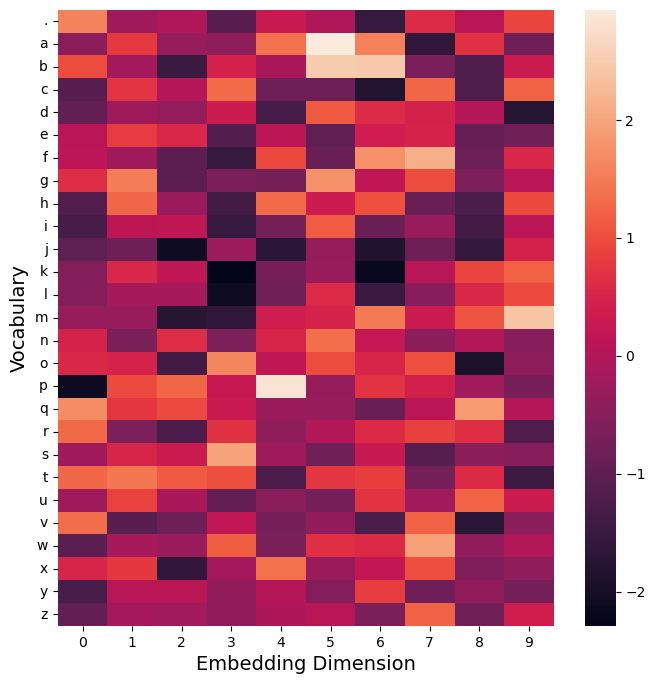

In [6]:
def plot_embedding(embedding: "torch.Tensor") -> None:
    _, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax = sns.heatmap(embedding.detach().numpy(), ax=ax)

    yticklabels = [int(label.get_text()) for label in ax.get_yticklabels()]
    yticklabels = [ITOS[label] for label in yticklabels]
    ax.set_yticklabels(yticklabels, rotation=0)
    ax.set_ylabel("Vocabulary", fontsize=14)
    ax.set_xlabel("Embedding Dimension", fontsize=14)


# Visualize embedding before training
plot_embedding(C)

In [ ]:
# Optimization loop
max_epoch = 200_000
optimal_rate = 0.1
batch_size = 32
loss_i = list()
update_info = list()

for epoch in range(max_epoch):

    # Construct a mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=generator)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]  # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update step with learning rate decay
    current_rate = 0.0
    if epoch < 0.5 * max_epoch:
        current_rate = optimal_rate
    elif epoch > 0.5 * max_epoch and epoch < 0.75 * max_epoch:
        current_rate = optimal_rate / 10
    elif epoch > 0.75 * max_epoch and epoch < 0.95 * max_epoch:
        current_rate = optimal_rate / 100
    else:
        current_rate = optimal_rate / 1000
    for p in parameters:
        p.data += -current_rate * p.grad

    # Track stats
    if epoch % 10_000 == 0:
        print(f"{epoch:7d}/{max_epoch:7d}: {loss.item():.4f}")
    loss_i.append(loss.log10().item())

    # Track information about how the network is being updated
    with torch.no_grad():
        update_info.append([(current_rate * p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 1.9320
      0/ 200000: 2.5657
      0/ 200000: 2.1682
      0/ 200000: 2.0911
      0/ 200000: 2.4364
      0/ 200000: 2.4578
      0/ 200000: 2.2570
      0/ 200000: 2.0425
      0/ 200000: 2.1999
      0/ 200000: 1.9448
      0/ 200000: 1.9019
      0/ 200000: 2.0325
      0/ 200000: 1.8002
      0/ 200000: 1.9392
      0/ 200000: 1.9168
      0/ 200000: 2.0285
      0/ 200000: 1.7801
      0/ 200000: 2.0677
      0/ 200000: 2.0546
      0/ 200000: 2.0127


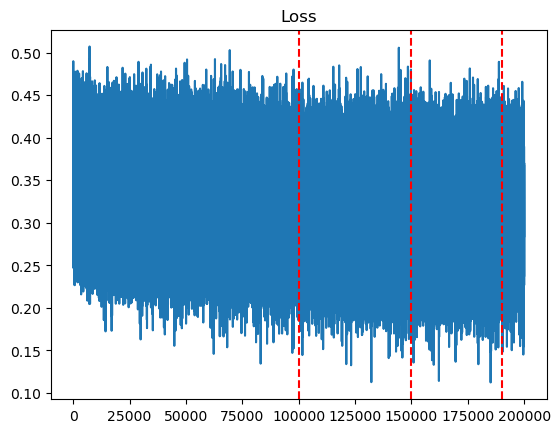

In [16]:
epoch_i = [i for i in range(max_epoch)]
plt.plot(epoch_i, loss_i)
decay_points = [0.5 * max_epoch, 0.75 * max_epoch, 0.95 * max_epoch]
for decay_point in decay_points:
    plt.axvline(int(decay_point), linestyle="--", color="r")
plt.title("Loss")
plt.show()

Text(0.5, 1.0, 'Activation Distribution')

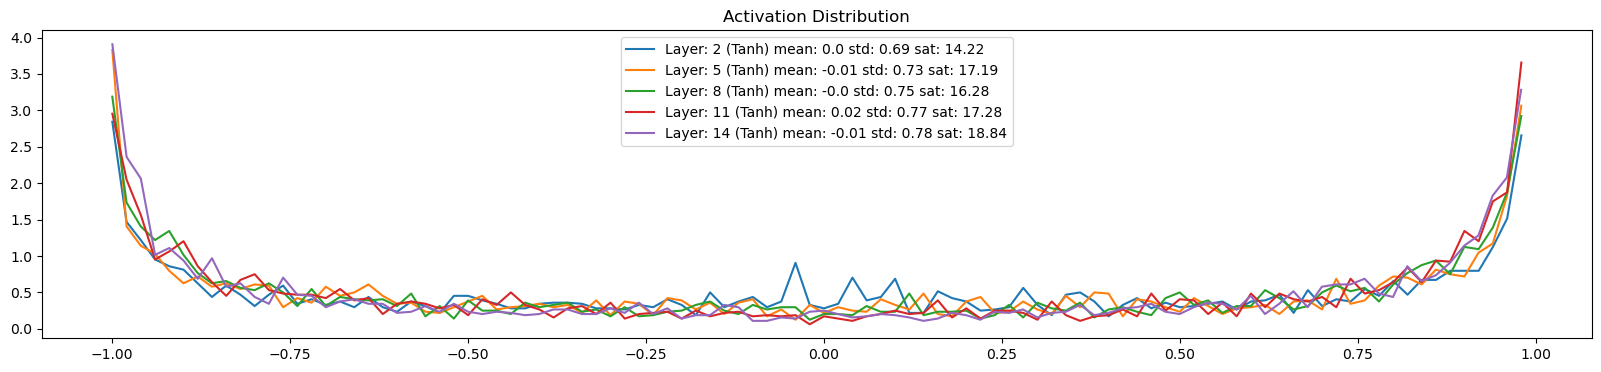

In [17]:
# Visualize the activation distribution and examine the effect of the forward pass on the activations

plt.figure(figsize=(20, 4))  # width and height of the plot
legends = list()

for i, layer in enumerate(layers[:-1]):  # Note that the output layer is excluded
    if isinstance(layer, Tanh):
        t = layer.out
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        mean = np.round(t.mean().detach().item(), 2)
        std = np.round(t.std().detach().item(), 2)
        saturation = np.round(((t.abs() > 0.97).float().mean() * 100).detach().item(), 2)
        legends.append(f"Layer: {i} ({layer.__class__.__name__}) mean: {mean} std: {std} sat: {saturation}")
plt.legend(legends)
plt.title("Activation Distribution")

Text(0.5, 1.0, 'Gradient Distribution')

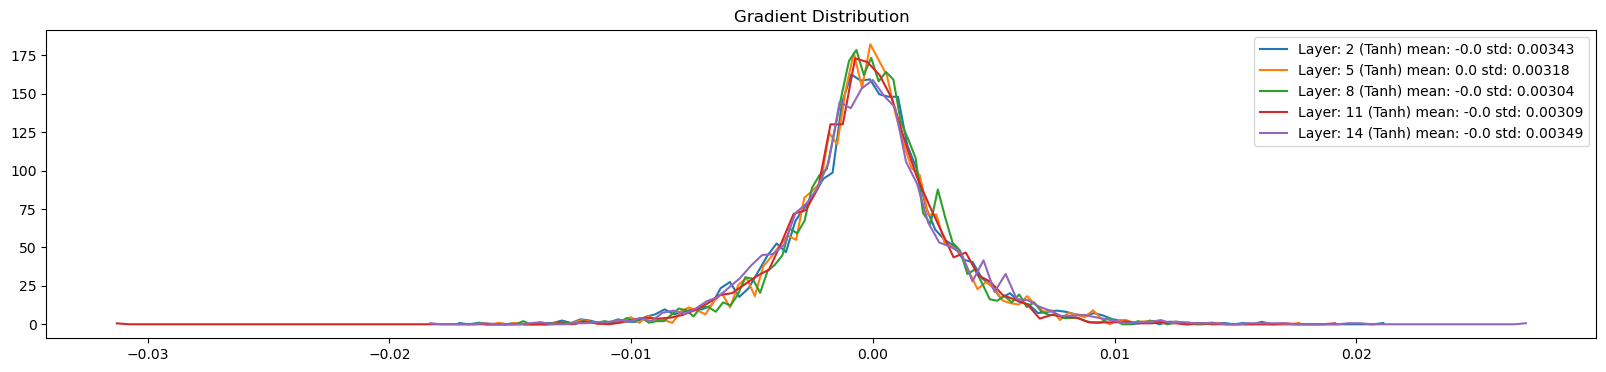

In [18]:
# Visualize the gradient distribution and look at the effect of the backward pass on the neural network

plt.figure(figsize=(20, 4))  # width and height of the plot
legends = list()

for i, layer in enumerate(layers[:-1]):  # Note that the output layer is excluded
    if isinstance(layer, Tanh):
        t = layer.out.grad
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        mean = np.round(t.mean().detach().item(), 5)
        std = np.round(t.std().detach().item(), 5)
        legends.append(f"Layer: {i} ({layer.__class__.__name__}) mean: {mean} std: {std}")
plt.legend(legends)
plt.title("Gradient Distribution")

Weight   (27, 10) | mean +0.000000 | std 1.467000e-02 | grad:data 1.334000e-02
Weight  (30, 100) | mean +0.000030 | std 7.470000e-03 | grad:data 1.790000e-02
Weight (100, 100) | mean +0.000040 | std 4.650000e-03 | grad:data 1.848000e-02
Weight (100, 100) | mean -0.000040 | std 4.800000e-03 | grad:data 1.947000e-02
Weight (100, 100) | mean +0.000030 | std 4.640000e-03 | grad:data 1.929000e-02
Weight (100, 100) | mean -0.000050 | std 4.330000e-03 | grad:data 1.866000e-02
Weight  (100, 27) | mean +0.000000 | std 8.270000e-03 | grad:data 2.460000e-02


Text(0.5, 1.0, 'Weights:Gradient Distribution')

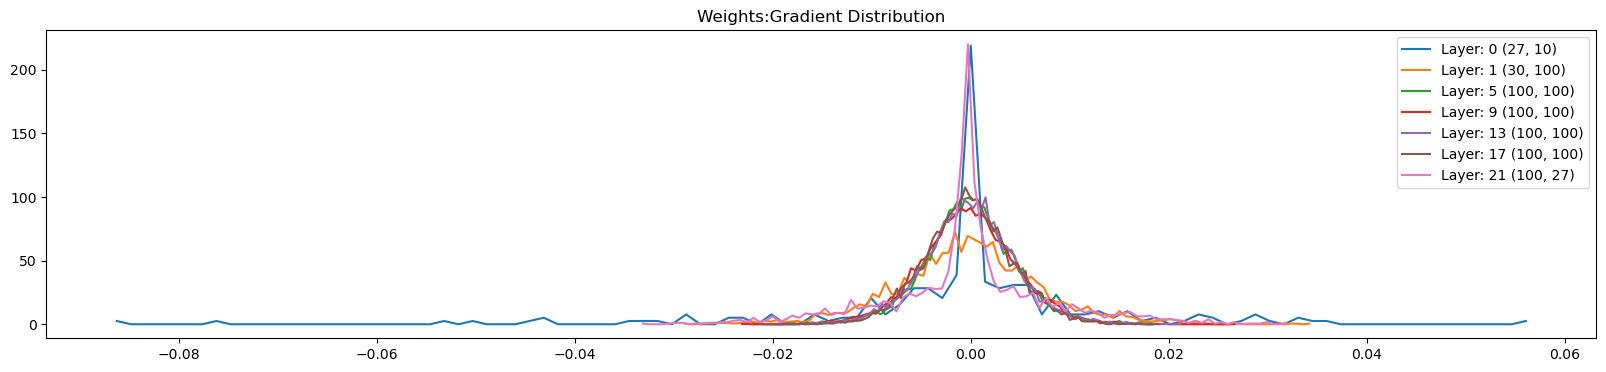

In [19]:
# Look at the relative size of the gradients vs the network weights and where the greatest
# effects are localized inside of the network

plt.figure(figsize=(20, 4))  # width and height of the plot
legends = list()

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        shape = p.shape
        mean = np.round(t.mean().detach().item(), 5)
        std = np.round(t.std().detach().item(), 5)
        grad_data_ratio = np.round((t.std() / p.std()).detach().item(), 5)
        print("Weight %10s | mean %+f | std %e | grad:data %e" % (tuple(shape), mean, std, grad_data_ratio))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer: {i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights:Gradient Distribution")

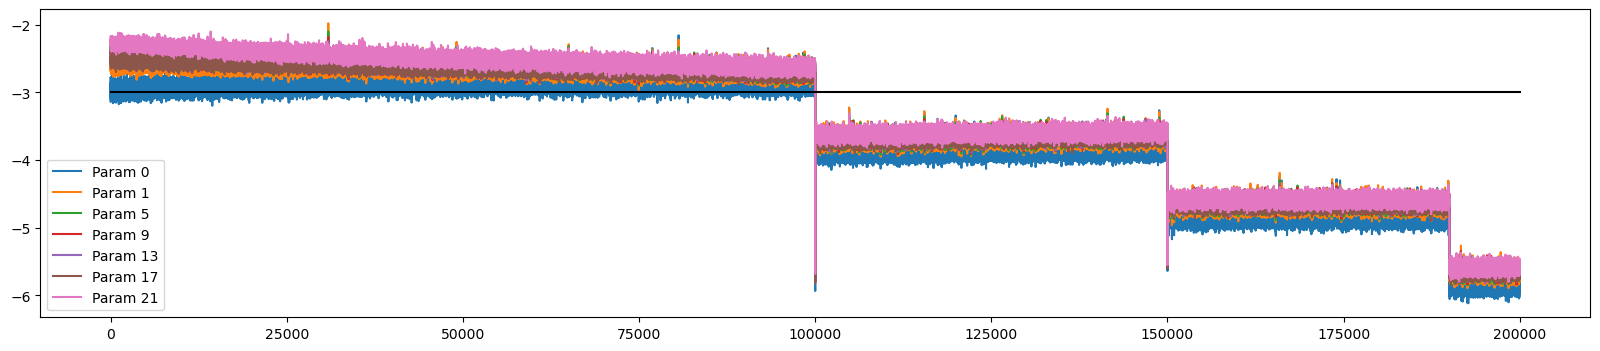

In [20]:
# The updates to the weights should be roughly equal to about 1/1000th of the magnitude of the
# values in the tensors. This plot can also reveal if the learning rate used for training is too small.
# For example, if the plotted lines are well below the black horizontal by a factor of 1 or 2 in log space
# that would indicate that the network is learning much to slowly. The opposite would also be true.

plt.figure(figsize=(20, 4))
legends = list()

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([update_info[j][i] for j in range(len(update_info))])
        legends.append(f"Param {i}")
plt.plot([0, len(update_info)], [-3, -3], "k")  # Ratios should generally settle around this value
plt.legend(legends)

In [32]:
# Sample from the model
n_samples = 10
with torch.no_grad():
    for _ in range(n_samples):

        out = []
        context = [0] * block_size
        while True:
            # Forward pass
            emb = C[torch.tensor([context])]  # (1, block_size, fan_in)
            x = emb.view(-1)
            for layer in layers:
                x = layer(x)
            probs = F.softmax(x, dim=0)
            ix = torch.multinomial(probs, num_samples=1, generator=generator).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print("".join(ITOS[i] for i in out))

nnn.
v.
nnz.
nnk.
nnn.
lh.
h.
csrn.
rhm.
skgn.


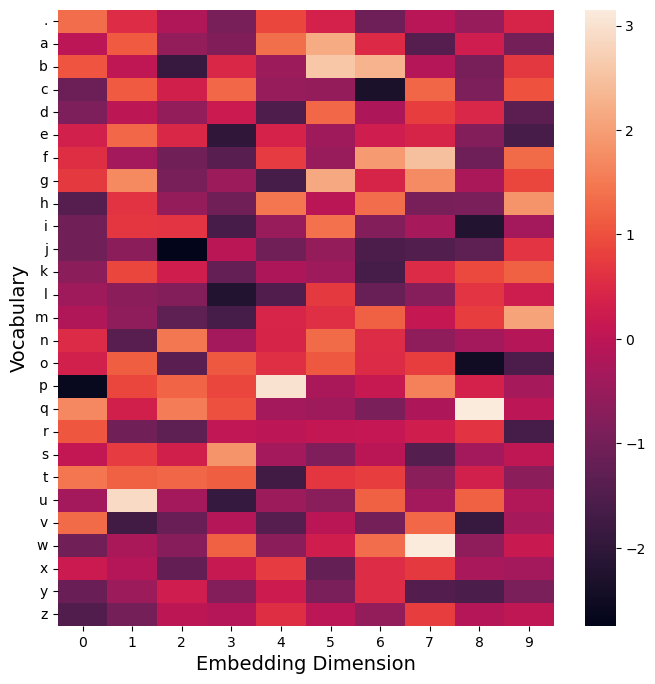

In [25]:
plot_embedding(C)